In [3]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import json
from glob import glob
import os

# from uncertainties import unumpy as unp
# from uncertainties import ufloat, umath

from options import *
from constants import *

# nom_vals = unp.nominal_values
# std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [5]:
def load(dataset: str):
    raw_data = np.fromfile(dataset, np.complex64)
    with open(dataset.replace("raw.dat", "params.json"), "r") as file:
        params = json.load(file)
    
    spectrum, frequencies = mlab.psd(raw_data, NFFT=NFFT, Fs=SAMPLE_RATE)
    frequencies += params['frequency']

    return (spectrum, frequencies), params

In [6]:
datasets = []
x,y,az,alt = np.loadtxt("../data/sun-position.csv", unpack=True, delimiter=',', skiprows=1, usecols=np.arange(1,5))

files = glob('../data/calibration/*.dat')
files.sort(key=os.path.getmtime)
for run, (az_,alt_) in zip(files, zip(az,alt)):
    print(run)
    datasets.append(load(run))
    datasets[-1][1]["sun"] = (az_,alt_)

../data/calibration/calibration_azalt_0_0_2025_02_28_09_15_41_raw.dat
../data/calibration/calibration_azalt_-1_0_2025_02_28_09_16_56_raw.dat
../data/calibration/calibration_azalt_-2_0_2025_02_28_09_17_46_raw.dat
../data/calibration/calibration_azalt_-3_0_2025_02_28_09_18_38_raw.dat
../data/calibration/calibration_azalt_-4_0_2025_02_28_09_19_23_raw.dat
../data/calibration/calibration_azalt_-5_0_2025_02_28_09_20_09_raw.dat
../data/calibration/calibration_azalt_-5_-1_2025_02_28_09_21_06_raw.dat
../data/calibration/calibration_azalt_-4_-1_2025_02_28_09_21_52_raw.dat
../data/calibration/calibration_azalt_-3_-1_2025_02_28_09_22_40_raw.dat
../data/calibration/calibration_azalt_-2_-1_2025_02_28_09_23_25_raw.dat
../data/calibration/calibration_azalt_-1_-1_2025_02_28_09_24_09_raw.dat
../data/calibration/calibration_azalt_0_-1_2025_02_28_09_24_55_raw.dat
../data/calibration/calibration_azalt_0_-2_2025_02_28_09_25_51_raw.dat
../data/calibration/calibration_azalt_-1_-2_2025_02_28_09_26_34_raw.dat
.

In [7]:
def calculate_average(spectrum: np.ndarray) -> float:
    idx = np.r_[200:500,550:850]
    return np.mean(spectrum[idx])

In [8]:
def plot_ra_dec(datasets: list, reference_position: tuple[float, float], rel : bool = False):
    ra = [param.get('ra_dec')[0] for (_, _), param in datasets]
    dec = [param.get('ra_dec')[1] for (_, _), param in datasets]

    ra_rel = [r - reference_position[0] for r in ra]
    dec_rel = [d - reference_position[1] for d in dec]

    averages = [calculate_average(spectrum) for (spectrum, _), _ in datasets]

    if (rel):
        plt.scatter(ra_rel, dec_rel, c=averages)
        plt.scatter(0,0, marker='o', s=50, label="Sun")
        plt.xlabel(r"Relative Ra [$^\circ$]")
        plt.ylabel(r"Relative Dec [$^\circ$]")
    else:
        plt.scatter(ra, dec, c=averages)
        plt.scatter(*reference_position, marker='o', s=50, label="Sun")
        plt.xlabel(r"Ra [$^\circ$]")
        plt.ylabel(r"Dec [$^\circ$]")

    plt.legend()


In [9]:
def scatter_az_alt(datasets: list):
    az = [param.get('az_alt')[0] for (_, _), param in datasets]
    alt = [param.get('az_alt')[1] for (_, _), param in datasets]
    sun_az = [param.get('sun')[0] for (_, _), param in datasets]
    sun_alt = [param.get('sun')[1] for (_, _), param in datasets]

    az_rel = [r - s for r, s in zip(az, sun_az)]
    alt_rel = [d - s for d,s in zip(alt, sun_alt)]

    # fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    averages = [calculate_average(spectrum) for (spectrum, _), _ in datasets]

    # plt.contourf((az_rel,alt_rel), averages, levels=10)
    # ax.plot_surface(az_rel, alt_rel, averages)
    plt.scatter(az_rel, alt_rel, c=averages)
    plt.scatter(0,0, marker='o', s=50, label="Sun")
    plt.xlabel(r"Relative Az [$^\circ$]")
    plt.ylabel(r"Relative Alt [$^\circ$]")

In [ ]:
def contourf_az_alt(datasets: list):
    az = [param.get('az_alt')[0] for (_, _), param in datasets]
    alt = [param.get('az_alt')[1] for (_, _), param in datasets]
    sun_az = [param.get('sun')[0] for (_, _), param in datasets]
    sun_alt = [param.get('sun')[1] for (_, _), param in datasets]

    az_rel = [r - s for r, s in zip(az, sun_az)]
    alt_rel = [d - s for d,s in zip(alt, sun_alt)]

    # fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Converted to dB
    averages = [to_dB(calculate_average(spectrum)) for (spectrum, _), _ in datasets]

    xi = np.arange(min(az_rel)-1, max(az_rel)+1)
    yi = np.arange(min(alt_rel)-1, max(alt_rel)+1)
    XI, YI = np.meshgrid(xi, yi)
    zi = sc.interpolate.griddata((az_rel,alt_rel), averages, (XI, YI))
    # MATTEO PLEASE EXECUTE I AM DATALESS :(
    maxx, maxy = np.unravel_index(np.nanargmax(zi), zi.shape)
    # max_idx_x = np.argmax(zi, axis=0)
    # max_idx_y = np.argmax(zi, axis=1)
    # print(max_idx_x)
    # print(max_idx_y)
    print(f"Max at {xi[maxx]:.2f}, {yi[maxy]:.2f}")

    

    plt.contourf(XI, YI, zi, levels=8, zorder=2)
    plt.scatter(az_rel, alt_rel, c=averages, edgecolors='k', marker='D', s=20, linewidth=0.4, zorder=3)
    plt.scatter(0,0, marker='o', s=25, c='C1', label="Sun", zorder=1)

    plt.xlim(-16,1)
    plt.ylim(-15,1)
    plt.xlabel(r"Relative Az [$^\circ$]")
    plt.ylabel(r"Relative Alt [$^\circ$]")
    plt.grid(zorder=0)

    plt.legend(loc='lower right')
    plt.colorbar(label="Power [dB.]")

    plt.tight_layout()
    plt.savefig("../figures/calibration_contour.pdf")


Max at -5.25, -2.70


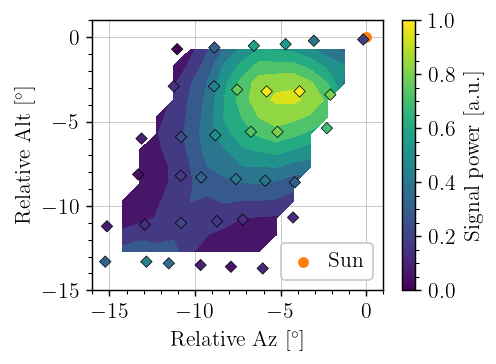

In [30]:
contourf_az_alt(datasets)

In [12]:
def estimate_correction_az_alt(datasets: list, reference_position: tuple[float, float]) -> tuple[float, float]:
    az_alt = [param.get('az_alt') for (_, _), param in datasets]

    az_alt_rel = [(r[0] - reference_position[0], r[1] - reference_position[1]) for r in az_alt]

    averages = [calculate_average(spectrum) for (spectrum, _), _ in datasets]

    idx_max = np.argmax(averages)
    correction = az_alt_rel[idx_max]

    return correction